In [1]:
import pandas as pd
import numpy as np
from pdvega import Axes as Vega

# Duration

This file splits each session into a series of phases: "typing", "viewing" and "inactive". For each session it then calculates the total time of each activity. Finally, it checks that no time has been "lost" in the process and stores the results.

In [2]:
all = pd.read_pickle("outputs/201907110900_data_preparation.pkl", compression="gzip")

## Parameters

In [3]:
max_inactivity = "00:00:30"

In [4]:
all = all.query("chart.str.contains('@alive') == False")

## Calculate the total duration of each session

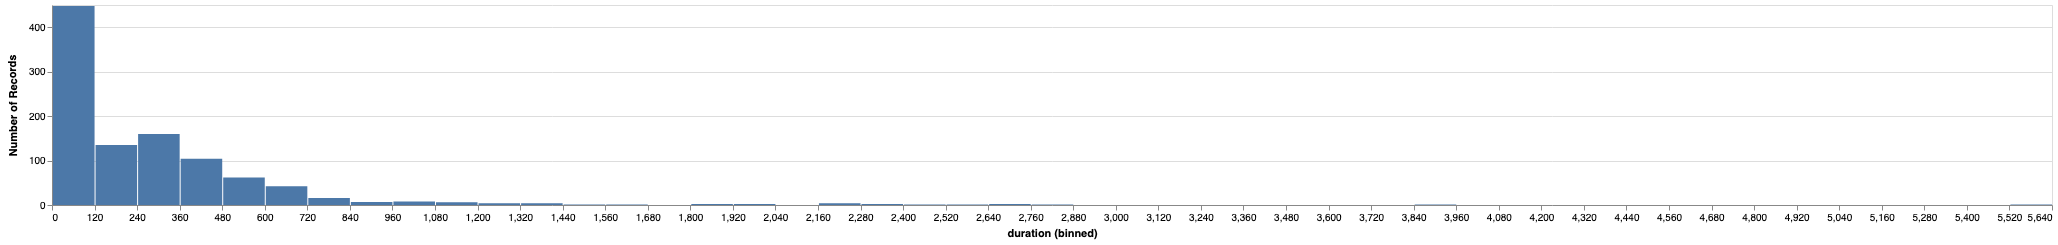

In [5]:
min = all.groupby("session").time.min()
max = all.query("chart.str.contains('@alive') == False").groupby("session").time.max()
time = max -min
all["duration"] = all.session.map(time)
all.duration = all.duration.dt.total_seconds()
Vega({
    "mark": "bar",
    "encoding": {
        "x": {"field": "duration", "bin": {"step": 120}, "type": "quantitative"},
        "y": {"aggregate": "count"}
    },
    "width": 2000
}, all.groupby("session").duration.first().reset_index())

## The different "charts" and what they signify

Possible chart types:
* `@init`: Start
* `@alive`: Inactive since more than 30s
* `@typing`: Keystroke
* `@answer`: Submitted answer
* `@message`: Used when to save the final code
* Something else: Some chart is shown

In [6]:
(all
    .query("chart.str.contains('@init') == False")
    .query("chart.str.contains('@alive') == False")
    .query("chart.str.contains('@typing') == False")
    .query("chart.str.contains('@answer') == False")
    .query("chart.str.contains('@message') == False")
    .chart.unique()
)

array(['demographics', 'gender', 'differences', 'uptick', 'aids', 'A',
       'AB', 'B', 'B1', 'BC', 'C', 'C1', 'CD', 'D', 'DE', 'E',
       'demographics-highlight', 'highlight', 'gender-differences',
       'differences-uptick', 'uptick-aids'], dtype=object)

## Phases

* `typing`: The time between sucessive `@typing` messages (if it's not longer than 30s)
* `viewing`: The time between sucessive statements that are not `@typing` or `@alive` (if it's not longer than 30s)
* `inactive`: The time that is not viewing or typing time

In [7]:
def segmenting(session):
    previous_time = None
    phase = None
    segments = []
    if(len(session) == 0):
        return segments
    min_time = all[all.session == session.session.iloc[0]].time.min()
    max_time = all[all.session == session.session.iloc[0]].time.max()
    for index, row in session.iterrows():
        if(phase == None): # Initialize
            assert("@init" in row.chart)
            assert (min_time == row.time), ("Min time", session.session.iloc[0], min_time, row.time)
            phase = {"name": "viewing", "start": row.time}
        elif(row.time == max_time): # Last entry
            segments.append({"name": phase["name"], "start": phase["start"], "end": row.time})
        elif( (row.time - previous_time) > pd.Timedelta(max_inactivity)):
            segments.append({"name": phase["name"], "start": phase["start"], "end": previous_time})
            segments.append({"name": "inactive", "start": previous_time, "end": row.time})
            if("@typing" in row.chart):
                phase = {"name": "typing", "start": row.time}
            else:
                phase = {"name": "viewing", "start": row.time}
        elif("@typing" in row.chart):
            if(phase["name"] != "typing"):
                assert(phase["name"] == "viewing")
                segments.append({"name": phase["name"], "start": phase["start"], "end": row.time})
                phase = {"name": "typing", "start": row.time}
        else:
            if(phase["name"] != "viewing"):
                assert(phase["name"] == "typing")
                segments.append({"name": phase["name"], "start": phase["start"], "end": row.time})
                phase = {"name": "viewing", "start": row.time}
        previous_time = row.time
    if(len(segments) > 0):
        assert segments[-1]["end"] == max_time, session
    return segments

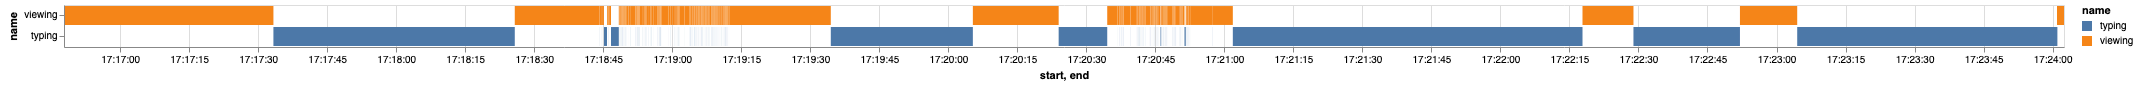

In [8]:
test = pd.DataFrame(
    segmenting(
        all.query("chart.str.contains('@alive') == False")
        .query("session == '1563211007791-0.jkkofmb689s'")
    )
)


Vega({
    "mark": "bar",
    "encoding": {
       "x": {"field": "start", "type": "temporal", "axis": {"format": "%H:%M:%S"}},
       "x2": {"field": "end", "type": "temporal"},
       "color": {"field": "name", "type": "nominal"},
       "y": {"field": "name", "type": "nominal", "sort": ["viewing", "typing", "inactive"]},
        
    }, "width": 2000
}, test)

## Segment everything

🛑  Warning: This can take a while

In [9]:
segments_per_session = (all
    .query("chart.str.contains('@alive') == False")
    .sort_values(["session", "time"])
    .groupby("session")
    .apply(segmenting)
)

## Check for gaps between the phases

There shouldn't be any gaps between phases. We also check for zero-length sessions.


In [10]:
for session in segments_per_session:
    test = pd.DataFrame(session)
    if(test.shape[0] == 0):
        print("Zero length:", session)
    else:
        test1 = test.shift(1)
        q = (test.start - test1.end)
        if(q[(q > "00:00:00")].shape[0] > 0):
            print("Gap in:", session)

Zero length: []
Zero length: []
Zero length: []
Zero length: []
Zero length: []


In [11]:
print(all.session.nunique())
print(len(segments_per_session))

1015
1015


## One row per phase

Now, the lists of phases gets expaned to one row per phase

In [12]:
segments_per_session_2 = (segments_per_session
 .reset_index()
 .rename({0: "phases"}, axis=1)
)


print(all.session.nunique())
print(len(segments_per_session_2))

sessions_segments = pd.DataFrame(columns=["session", "name", "start", "end"])

for i, session in segments_per_session_2.iterrows():
    segments = pd.DataFrame(session[1])
    segments["session"] = session[0]
    sessions_segments = sessions_segments.append(segments, ignore_index=True, sort=False)

sessions_segments.start = pd.to_datetime(sessions_segments.start)
sessions_segments.end = pd.to_datetime(sessions_segments.end)
sessions_segments = sessions_segments[["session", "name", "start", "end"]]
print(sessions_segments.session.nunique())
print(sessions_segments.session.shape[0])
sessions_segments.head()

1015
1015
1010
17015


,session,name,start,end
0,1562865674704-0.46qaerk672y,viewing,2019-07-11 17:21:14.704,2019-07-11 17:21:14.706
1,1562865716524-0.9588yccch9p,viewing,2019-07-11 17:21:56.524,2019-07-11 17:21:56.527
2,1562865729193-0.b85m3ku7ze,viewing,2019-07-11 17:22:09.194,2019-07-11 17:22:09.208
3,1562865740910-0.32bb4l22udl,viewing,2019-07-11 17:22:20.910,2019-07-11 17:23:32.374
4,1562865814651-0.3jmq3qamdin,viewing,2019-07-11 17:23:34.651,2019-07-11 17:23:34.651


## Check for gaps (again)

You can never be too sure

In [13]:
sessions_segments["prev_end"] = sessions_segments.groupby("session").shift(1).end
(sessions_segments.start - sessions_segments.prev_end).max()

Timedelta('0 days 00:00:00')

## Check if start and end times are the same for a session before and after processing

In [14]:
a_starts = all.groupby("session").time.min().reset_index().rename({"time": "a_starts"}, axis=1)
a_ends = all.groupby("session").time.max().reset_index().rename({"time": "a_ends"}, axis=1)


b_starts = sessions_segments.groupby("session").start.min().reset_index()
b_ends = sessions_segments.groupby("session").end.max().reset_index()

start_end = (pd.merge(a_starts, a_ends, on="session").merge(b_starts, on="session").merge(b_ends, on="session"))
start_end[start_end["a_starts"] != start_end["start"]]

,session,a_starts,a_ends,start,end


In [15]:
start_end[start_end["a_ends"] != start_end["end"]]

,session,a_starts,a_ends,start,end


## Calculate totals

For each phase and per session

In [16]:
sessions_segments["phase_duration"] = (sessions_segments.end - sessions_segments.start).dt.total_seconds()

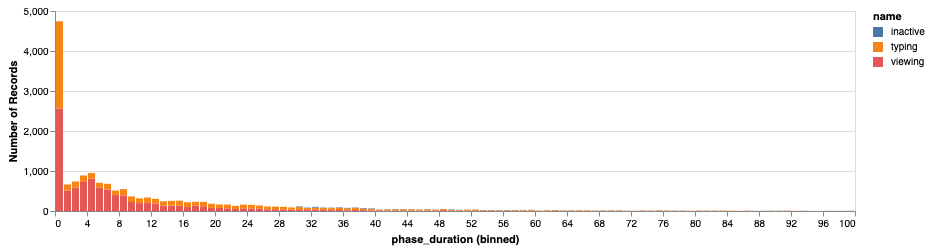

In [17]:
Vega({
    "mark": "bar",
    "encoding": {
        "x": {"field": "phase_duration", "bin": {"step": 1}, "type": "quantitative"},
        "y": {"aggregate": "count"},
        "color": {"field": "name", "type": "nominal"}
    }, "width": 800
}, sessions_segments.query("phase_duration < 100"))

In [18]:
def total_time_per_session(sessions_segments, name):
    print(sessions_segments.query("name == '"+name+"'")
              .session.nunique()
         )
    return (sessions_segments
                        .query("name == '"+name+"'")
                        .groupby("session")
                        .phase_duration.sum()
                        .reset_index()
                        .rename({"phase_duration": name}, axis=1)
                       ) 

## Inactivity



307


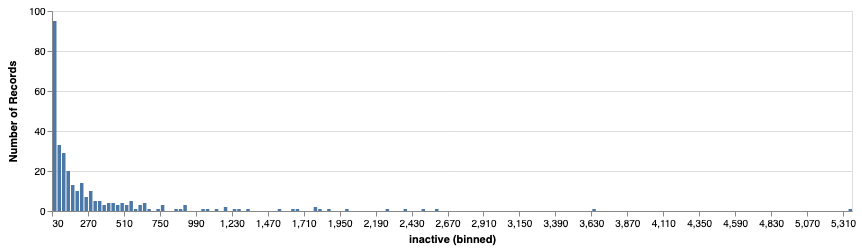

In [19]:
inactive_per_session = total_time_per_session(sessions_segments, "inactive")
Vega({
    "mark": "bar",
    "encoding": {
        "x": {"field": "inactive", "bin": {"step": 30}, "type": "quantitative"},
        "y": {"aggregate": "count"},
    }, "width": 800
}, inactive_per_session.query("inactive > 0"))

## Typing time


680


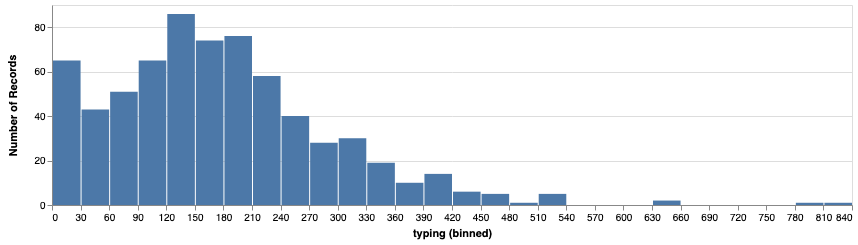

In [20]:
typing_per_session = total_time_per_session(sessions_segments, "typing")
Vega({
    "mark": "bar",
    "encoding": {
        "x": {"field": "typing", "bin": {"step": 30}, "type": "quantitative"},
        "y": {"aggregate": "count"},
    }, "width": 800
}, typing_per_session.query("typing > 0"))

## Viewing time

1010


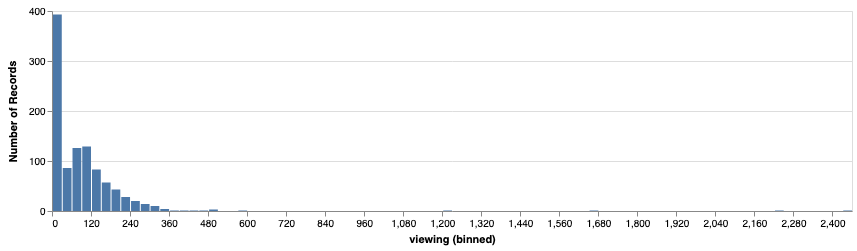

In [28]:
viewing_per_session = total_time_per_session(sessions_segments, "viewing")
Vega({
    "mark": "bar",
    "encoding": {
        "x": {"field": "viewing", "bin": {"step": 30}, "type": "quantitative"},
        "y": {"aggregate": "count"},
    }, "width": 800
}, viewing_per_session.query("viewing > 0"))

## Check if the total duration is the same as the sum of all the phase durations

In [22]:
total_per_session = (viewing_per_session
                     .merge(typing_per_session, on="session", how="outer")
                     .merge(inactive_per_session, on="session", how="outer")
                    )
total_per_session["total"] = total_per_session.viewing + total_per_session.typing + total_per_session.inactive
total_per_session.typing.fillna(0, inplace=True)
total_per_session.inactive.fillna(0, inplace=True)
total_per_session.head()
total_per_session.shape[0]

1010

In [23]:
c = all.filter(["session", "duration"]).merge(total_per_session, on="session")
c["difference"] = c.duration - c.total
c[c.difference > 1]

,session,duration,viewing,typing,inactive,total,difference


## Merge the phase durations to the complete DataFrame

In [30]:
print(all.shape[0])
all_with_phases = pd.merge(all, total_per_session, on="session", how="left").drop(["total"], axis=1)
print(all_with_phases.shape[0])
all_with_phases.query("transition.isna() == False").columns

688664
688664


Index(['time', 'source', 'user', 'session', 'userAgent', 'screenWidth',
       'screenHeight', 'windowWidth', 'windowHeight', 'resolution', 'chart',
       'relativePosition', 'absolutePosition', 'message', 'story', 'substory',
       'layout', 'transition', 'condition', 'duration', 'viewing', 'typing',
       'inactive'],
      dtype='object')

## Save result

In [25]:
all_with_phases.to_pickle("outputs/201907111000_duration.pkl", compression="gzip")

In [26]:
sessions_segments.to_pickle("outputs/201907111000_time_segments.pkl", compression="gzip")

In [27]:
print(all.session.nunique())
print(sessions_segments.session.nunique())
print(total_per_session.session.nunique())

1015
1010
1010
